# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.Resize(image_size),
        #transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ]))
    
    print(dataset)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    #n = iter(dataloader).next()
    #print(len(n))
    #print([x.shape for x in n])
    
    return dataloader

get_dataloader(16, 32)

Dataset ImageFolder
    Number of datapoints: 89931
    Root location: processed_celeba_small/


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Dataset ImageFolder
    Number of datapoints: 89931
    Root location: processed_celeba_small/


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

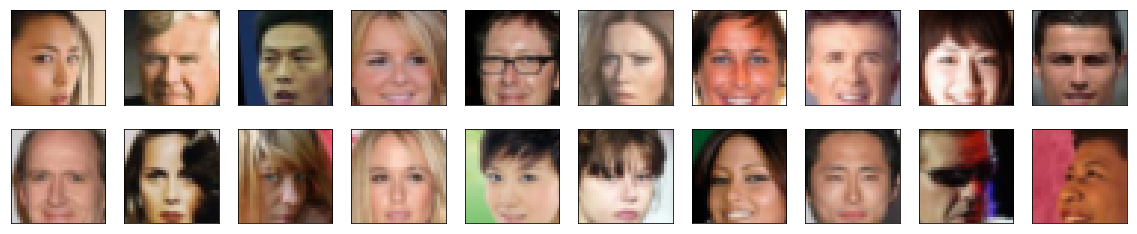

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    #min, max = torch.min(x), torch.max(x)
    #print(min, max)
    
    return (x * (feature_range[1] - feature_range[0])) + feature_range[0]


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8980)
Max:  tensor(0.9059)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True):
            conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
            
            if batch_norm:
                return nn.Sequential(conv_layer, nn.BatchNorm2d(out_channels))
            else:
                return conv_layer

        # complete init function
        
        # 3, 32, 32
        self.conv1 = conv(3, conv_dim, bias=True, batch_norm=False)
        # conv_dim, 16, 16
        self.conv2 = conv(conv_dim, conv_dim * 2)
        # conv_dim * 2, 8, 8
        self.conv3 = conv(conv_dim * 2, conv_dim * 4)
        # conv_dim * 4, 4, 4
        self.conv4 = conv(conv_dim * 4, conv_dim * 4, kernel_size=3, stride=1)
        # conv_dim * 4, 4, 4
        self.linear_input_size = conv_dim * 4 * 4 * 4
        self.fc1 = nn.Sequential(nn.Linear(self.linear_input_size, self.linear_input_size), nn.BatchNorm1d(self.linear_input_size))
        self.fc2 = nn.Linear(self.linear_input_size, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        #print(x.shape)
        out = x.view(-1, 3, 32, 32)
        #print(out.shape)
        out = F.leaky_relu(self.conv1(out), 0.2)
        #print(out.shape)
        out = F.leaky_relu(self.conv2(out), 0.2)
        #print(out.shape)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        #print(out.shape)
        out = out.view(-1, self.linear_input_size)
        out = F.leaky_relu(self.fc1(out), 0.2)
        out = self.fc2(out)
        #out = torch.sigmoid(out)
        #print(out.shape)
        
        return out
        #return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        def tconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True):
            tconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
            
            if batch_norm:
                return nn.Sequential(tconv_layer, nn.BatchNorm2d(out_channels))
            else:
                return tconv_layer
        
        self.z_size = z_size
        self.conv_dim = conv_dim
        self.fc1 = nn.Sequential(nn.Linear(z_size, conv_dim * 4 * 4 * 4), nn.BatchNorm1d(conv_dim * 4 * 4 * 4))
        self.fc2 = nn.Sequential(nn.Linear(conv_dim * 4 * 4 * 4, conv_dim * 4 * 4 * 4), nn.BatchNorm1d(conv_dim * 4 * 4 * 4))
        self.tconv1 = tconv(conv_dim * 4, conv_dim * 4, kernel_size=3, stride=1)
        self.tconv1a = tconv(conv_dim * 4, conv_dim * 4, kernel_size=3, stride=1)
        self.tconv2 = tconv(conv_dim * 4, conv_dim * 2)
        self.tconv3 = tconv(conv_dim * 2, conv_dim)
        self.tconv4 = tconv(conv_dim, 3, bias=True, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = x.view(-1, self.z_size)
        #print(out.shape, self.z_size)
        out = F.relu(self.fc1(out))
        #print(out.shape)
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = out.view(-1, self.conv_dim * 4, 4, 4)
        #print(out.shape)
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv1a(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        out = torch.tanh(self.tconv4(out))
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [11]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname == 'Linear' or classname.find('Conv') != -1:
        print(classname)
        m.weight.data.normal_(0, 0.02)
        if classname == 'Linear':
            m.bias.data.fill_(0)
    
d = Discriminator(10)
d.apply(weights_init_normal)
g = Generator(30, 10)
g.apply(weights_init_normal)

print(d)
print(g)

Conv2d
Conv2d
Conv2d
Conv2d
Linear
Linear
Linear
Linear
ConvTranspose2d
ConvTranspose2d
ConvTranspose2d
ConvTranspose2d
ConvTranspose2d
Discriminator(
  (conv1): Conv2d(3, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=640, out_features=640, bias=True)
    (1): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [13]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

#print(D(torch.rand(10, 3, 32, 32) * 2 - 1))
print(G(torch.rand(2, z_size)))

Conv2d
Conv2d
Conv2d
Conv2d
Linear
Linear
Linear
Linear
ConvTranspose2d
ConvTranspose2d
ConvTranspose2d
ConvTranspose2d
ConvTranspose2d
Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, trac

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [15]:
cel = nn.CrossEntropyLoss()

def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    #loss = torch.mean(torch.abs(1 - D_out))
    """
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.ones(D_out.size(0))
    if smooth:
        labels *= 0.9
    labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    """
    loss = torch.mean((1 - D_out.squeeze())**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    """
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.zeros(D_out.size(0)).cuda()
    loss = criterion(D_out.squeeze(), labels)
    """
    loss = torch.mean(D_out.squeeze()**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [16]:
import torch.optim as optim

lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, (beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, (beta1, beta2))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [35]:
def gen_samples(z=None, nrows=2, ncols=8, save_to_file=""):
    fig, axes = plt.subplots(figsize=(ncols*2, nrows*2), nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    gen_images = G((torch.rand(nrows*ncols, z_size) * 2 - 1.0).cuda()) if z is None else G(z)
    #print(gen_images.shape)
    #print(gen_images)
    
    for ax, img in zip(axes.flatten(), gen_images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    if save_to_file:
        plt.savefig(save_to_file)
        plt.close()


In [27]:
def train(D, G, n_epochs, start_epoch_num=0, n_pre_training_epochs=1, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    
    def gen_z(sample_size):
        z = np.random.uniform(-1, 1, size=(sample_size, z_size))
        z = torch.from_numpy(z).float()
        # move z to GPU if available
        if train_on_gpu:
            z = z.cuda()
        return z

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = gen_z(sample_size)

    gen_samples(z=fixed_z, nrows=4, ncols=4, save_to_file=f'epoch{start_epoch_num}.png')
    
    def train_d(batch_size, fake_size, real_images):
        d_optimizer.zero_grad()

        d_real_loss = real_loss(D(real_images))

        latent_vectors = gen_z(fake_size)
        fake_images = G(latent_vectors)
        d_fake_loss = fake_loss(D(fake_images))

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optimizer.step()
        return d_real_loss, d_fake_loss, d_loss

    def train_g(fake_size):
        g_optimizer.zero_grad()

        latent_vectors = gen_z(fake_size)
        fake_images = G(latent_vectors)

        fake_d = D(fake_images)
        g_loss = real_loss(fake_d)

        g_loss.backward()
        g_optimizer.step()
        return g_loss

    for epoch in range(n_pre_training_epochs):
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            batch_size = real_images.size(0)
            fake_size = batch_size
            real_images = scale(real_images).cuda()
            d_real_loss, d_fake_loss, d_loss = train_d(batch_size, fake_size, real_images)
            if batch_i % print_every == 0:
                print('Pre-discriminator-training | d_real_loss: {:6.8f} | d_fake_loss: {:6.8f}'.format(
                        d_real_loss.item(), d_fake_loss.item()))

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images).cuda()
            fake_size = batch_size

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_real_loss, d_fake_loss, d_loss = train_d(batch_size, fake_size, real_images)

            # 2. Train the generator with an adversarial loss
            g_loss = train_g(fake_size)
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_real_loss: {:6.8f} | d_fake_loss: {:6.8f} | g_loss: {:6.8f}'.format(
                        epoch+start_epoch_num+1, n_epochs+start_epoch_num, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
                
                #G.eval()
                #gen_samples(z=fixed_z, nrows=4, ncols=4, save_to_file=f'latest.png')
                #G.train()


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        gen_samples(z=fixed_z, nrows=4, ncols=4, save_to_file=f'epoch{epoch+start_epoch_num+1}.png')
        torch.save(D.state_dict(), f'd_state_dict.pth')
        torch.save(G.state_dict(), f'g_state_dict.pth')
        
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 50
start_epoch_num = 0


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, n_pre_training_epochs=1, start_epoch_num=start_epoch_num)

Pre-discriminator-training | d_real_loss: 1.24398303 | d_fake_loss: 0.56027019
Pre-discriminator-training | d_real_loss: 2.16298914 | d_fake_loss: 0.55793816
Pre-discriminator-training | d_real_loss: 1.23292446 | d_fake_loss: 0.58140802
Pre-discriminator-training | d_real_loss: 0.48920813 | d_fake_loss: 0.60586458
Pre-discriminator-training | d_real_loss: 0.50396919 | d_fake_loss: 0.52542245
Pre-discriminator-training | d_real_loss: 0.35734999 | d_fake_loss: 0.54343534
Pre-discriminator-training | d_real_loss: 0.31338912 | d_fake_loss: 0.44060817
Pre-discriminator-training | d_real_loss: 0.33699453 | d_fake_loss: 0.40154409
Pre-discriminator-training | d_real_loss: 0.75221407 | d_fake_loss: 0.37109768
Pre-discriminator-training | d_real_loss: 0.73450238 | d_fake_loss: 0.37907392
Pre-discriminator-training | d_real_loss: 0.38436729 | d_fake_loss: 0.32784134
Pre-discriminator-training | d_real_loss: 0.17650768 | d_fake_loss: 0.30699140
Pre-discriminator-training | d_real_loss: 0.18602173

Epoch [    1/   50] | d_real_loss: 0.19790915 | d_fake_loss: 0.18981892 | g_loss: 0.33134535
Epoch [    1/   50] | d_real_loss: 0.26511347 | d_fake_loss: 0.18835339 | g_loss: 0.34477240
Epoch [    1/   50] | d_real_loss: 0.13069846 | d_fake_loss: 0.25128424 | g_loss: 0.37278068
Epoch [    1/   50] | d_real_loss: 0.21846992 | d_fake_loss: 0.11622605 | g_loss: 0.48807138
Epoch [    1/   50] | d_real_loss: 0.20235069 | d_fake_loss: 0.26758671 | g_loss: 0.48529071
Epoch [    1/   50] | d_real_loss: 0.11401215 | d_fake_loss: 0.37123239 | g_loss: 0.36568147
Epoch [    1/   50] | d_real_loss: 0.23443270 | d_fake_loss: 0.27553114 | g_loss: 0.29094917
Epoch [    1/   50] | d_real_loss: 0.18059680 | d_fake_loss: 0.20268032 | g_loss: 0.41138434
Epoch [    1/   50] | d_real_loss: 0.22956920 | d_fake_loss: 0.33465135 | g_loss: 0.68158722
Epoch [    1/   50] | d_real_loss: 0.31559169 | d_fake_loss: 0.17527521 | g_loss: 0.44340232
Epoch [    1/   50] | d_real_loss: 0.23844671 | d_fake_loss: 0.2661736

Epoch [    3/   50] | d_real_loss: 0.24930853 | d_fake_loss: 0.21314043 | g_loss: 0.35990068
Epoch [    3/   50] | d_real_loss: 0.29327068 | d_fake_loss: 0.12155867 | g_loss: 0.29081461
Epoch [    3/   50] | d_real_loss: 0.14432290 | d_fake_loss: 0.31833333 | g_loss: 0.40619016
Epoch [    3/   50] | d_real_loss: 0.24336633 | d_fake_loss: 0.23619165 | g_loss: 0.53079259
Epoch [    3/   50] | d_real_loss: 0.11718646 | d_fake_loss: 0.14832616 | g_loss: 0.51643646
Epoch [    3/   50] | d_real_loss: 0.18066457 | d_fake_loss: 0.15095094 | g_loss: 0.47983718
Epoch [    3/   50] | d_real_loss: 0.11928956 | d_fake_loss: 0.22677211 | g_loss: 0.46620730
Epoch [    3/   50] | d_real_loss: 0.16943991 | d_fake_loss: 0.17580348 | g_loss: 0.43349195
Epoch [    3/   50] | d_real_loss: 0.17245832 | d_fake_loss: 0.12431838 | g_loss: 0.47832841
Epoch [    3/   50] | d_real_loss: 0.14037219 | d_fake_loss: 0.15378937 | g_loss: 0.42707604
Epoch [    3/   50] | d_real_loss: 0.31099755 | d_fake_loss: 0.1056536

Epoch [    4/   50] | d_real_loss: 0.11529712 | d_fake_loss: 0.20024599 | g_loss: 0.69611597
Epoch [    4/   50] | d_real_loss: 0.16603433 | d_fake_loss: 0.31616241 | g_loss: 0.13388011
Epoch [    4/   50] | d_real_loss: 0.39501628 | d_fake_loss: 0.09214287 | g_loss: 0.25569522
Epoch [    4/   50] | d_real_loss: 0.07307577 | d_fake_loss: 0.28069612 | g_loss: 0.52801383
Epoch [    4/   50] | d_real_loss: 0.15485343 | d_fake_loss: 0.28269514 | g_loss: 0.35675904
Epoch [    4/   50] | d_real_loss: 0.23807931 | d_fake_loss: 0.19803041 | g_loss: 0.55899584
Epoch [    4/   50] | d_real_loss: 0.15577224 | d_fake_loss: 0.27817765 | g_loss: 0.52175307
Epoch [    4/   50] | d_real_loss: 0.29609525 | d_fake_loss: 0.09917074 | g_loss: 0.47833878
Epoch [    4/   50] | d_real_loss: 0.11155590 | d_fake_loss: 0.17385647 | g_loss: 0.56632400
Epoch [    4/   50] | d_real_loss: 0.21613568 | d_fake_loss: 0.12990785 | g_loss: 0.34166858
Epoch [    4/   50] | d_real_loss: 0.12530790 | d_fake_loss: 0.2564694

Epoch [    6/   50] | d_real_loss: 0.13952954 | d_fake_loss: 0.21950766 | g_loss: 0.53036779
Epoch [    6/   50] | d_real_loss: 0.16633637 | d_fake_loss: 0.08033808 | g_loss: 0.61994362
Epoch [    6/   50] | d_real_loss: 0.16980997 | d_fake_loss: 0.18473661 | g_loss: 0.66595840
Epoch [    6/   50] | d_real_loss: 0.08545126 | d_fake_loss: 0.13440380 | g_loss: 0.23743716
Epoch [    6/   50] | d_real_loss: 0.13392746 | d_fake_loss: 0.21594228 | g_loss: 0.73359334
Epoch [    6/   50] | d_real_loss: 0.13729876 | d_fake_loss: 0.21907571 | g_loss: 0.37308085
Epoch [    6/   50] | d_real_loss: 0.06204008 | d_fake_loss: 0.21134035 | g_loss: 0.67695796
Epoch [    6/   50] | d_real_loss: 0.27701601 | d_fake_loss: 0.07632215 | g_loss: 0.50788850
Epoch [    6/   50] | d_real_loss: 0.07231663 | d_fake_loss: 0.14602202 | g_loss: 0.32720441
Epoch [    6/   50] | d_real_loss: 0.09451930 | d_fake_loss: 0.25748274 | g_loss: 0.65197927
Epoch [    6/   50] | d_real_loss: 0.36747289 | d_fake_loss: 0.1231856

Epoch [    7/   50] | d_real_loss: 0.06243276 | d_fake_loss: 0.14765090 | g_loss: 0.72768056
Epoch [    7/   50] | d_real_loss: 0.14032809 | d_fake_loss: 0.19138640 | g_loss: 0.43222332
Epoch [    7/   50] | d_real_loss: 0.10180253 | d_fake_loss: 0.17076987 | g_loss: 0.41199970
Epoch [    7/   50] | d_real_loss: 0.07485276 | d_fake_loss: 0.24705994 | g_loss: 0.36322773
Epoch [    7/   50] | d_real_loss: 0.17840064 | d_fake_loss: 0.04384476 | g_loss: 0.61841464
Epoch [    7/   50] | d_real_loss: 0.05917098 | d_fake_loss: 0.17511284 | g_loss: 0.51905501
Epoch [    7/   50] | d_real_loss: 0.05899863 | d_fake_loss: 0.28183150 | g_loss: 0.52530676
Epoch [    7/   50] | d_real_loss: 0.25766000 | d_fake_loss: 0.19887070 | g_loss: 0.46815780
Epoch [    8/   50] | d_real_loss: 0.07026071 | d_fake_loss: 0.31664827 | g_loss: 0.62933564
Epoch [    8/   50] | d_real_loss: 0.17914075 | d_fake_loss: 0.05701063 | g_loss: 0.58423942
Epoch [    8/   50] | d_real_loss: 0.05395973 | d_fake_loss: 0.1363702

Epoch [    9/   50] | d_real_loss: 0.13134676 | d_fake_loss: 0.12290657 | g_loss: 0.39691180
Epoch [    9/   50] | d_real_loss: 0.09957676 | d_fake_loss: 0.24877182 | g_loss: 0.61130214
Epoch [    9/   50] | d_real_loss: 0.08584808 | d_fake_loss: 0.06791668 | g_loss: 0.76752520
Epoch [    9/   50] | d_real_loss: 0.22799602 | d_fake_loss: 0.11342094 | g_loss: 0.23128036
Epoch [    9/   50] | d_real_loss: 0.10449679 | d_fake_loss: 0.19489923 | g_loss: 0.72523314
Epoch [    9/   50] | d_real_loss: 0.09661031 | d_fake_loss: 0.28742903 | g_loss: 0.67824775
Epoch [    9/   50] | d_real_loss: 0.05171530 | d_fake_loss: 0.09540676 | g_loss: 0.58330476
Epoch [    9/   50] | d_real_loss: 0.05524705 | d_fake_loss: 0.20723483 | g_loss: 0.87598801
Epoch [    9/   50] | d_real_loss: 0.08334783 | d_fake_loss: 0.15240823 | g_loss: 0.60025781
Epoch [    9/   50] | d_real_loss: 0.11097811 | d_fake_loss: 0.04450005 | g_loss: 0.59891844
Epoch [    9/   50] | d_real_loss: 0.30913034 | d_fake_loss: 0.1291969

Epoch [   10/   50] | d_real_loss: 0.16317829 | d_fake_loss: 0.14706168 | g_loss: 0.56988871
Epoch [   10/   50] | d_real_loss: 0.06535703 | d_fake_loss: 0.19151503 | g_loss: 1.05836701
Epoch [   10/   50] | d_real_loss: 0.15396574 | d_fake_loss: 0.04628789 | g_loss: 0.44321990
Epoch [   11/   50] | d_real_loss: 0.24590509 | d_fake_loss: 0.13865490 | g_loss: 0.78853178
Epoch [   11/   50] | d_real_loss: 0.17708242 | d_fake_loss: 0.11422817 | g_loss: 0.72503382
Epoch [   11/   50] | d_real_loss: 0.08582358 | d_fake_loss: 0.13051499 | g_loss: 0.80071485
Epoch [   11/   50] | d_real_loss: 0.09812876 | d_fake_loss: 0.08239128 | g_loss: 0.56792724
Epoch [   11/   50] | d_real_loss: 0.11514314 | d_fake_loss: 0.10334797 | g_loss: 0.73381263
Epoch [   11/   50] | d_real_loss: 0.15231684 | d_fake_loss: 0.16805491 | g_loss: 0.31778812
Epoch [   11/   50] | d_real_loss: 0.35599017 | d_fake_loss: 0.03554302 | g_loss: 0.56715095
Epoch [   11/   50] | d_real_loss: 0.03115637 | d_fake_loss: 0.2201431

Epoch [   12/   50] | d_real_loss: 0.10467222 | d_fake_loss: 0.11054900 | g_loss: 0.67869425
Epoch [   12/   50] | d_real_loss: 0.08517789 | d_fake_loss: 0.05944580 | g_loss: 0.73379064
Epoch [   12/   50] | d_real_loss: 0.07267020 | d_fake_loss: 0.38110167 | g_loss: 1.07419074
Epoch [   12/   50] | d_real_loss: 0.09450248 | d_fake_loss: 0.10055614 | g_loss: 0.70336324
Epoch [   12/   50] | d_real_loss: 0.22288823 | d_fake_loss: 0.03686555 | g_loss: 0.70071191
Epoch [   12/   50] | d_real_loss: 0.03194965 | d_fake_loss: 0.09126514 | g_loss: 0.99077320
Epoch [   12/   50] | d_real_loss: 0.03430324 | d_fake_loss: 0.21546715 | g_loss: 0.74364877
Epoch [   12/   50] | d_real_loss: 0.09576872 | d_fake_loss: 0.05233441 | g_loss: 0.53994256
Epoch [   12/   50] | d_real_loss: 0.16378039 | d_fake_loss: 0.10808532 | g_loss: 0.88754290
Epoch [   12/   50] | d_real_loss: 0.06458846 | d_fake_loss: 0.13415554 | g_loss: 0.64505202
Epoch [   12/   50] | d_real_loss: 0.05388670 | d_fake_loss: 0.1422914

Epoch [   14/   50] | d_real_loss: 0.03973046 | d_fake_loss: 0.08486639 | g_loss: 1.06607151
Epoch [   14/   50] | d_real_loss: 0.12029062 | d_fake_loss: 0.26463091 | g_loss: 1.06321216
Epoch [   14/   50] | d_real_loss: 0.09914766 | d_fake_loss: 0.12176891 | g_loss: 1.13882899
Epoch [   14/   50] | d_real_loss: 0.03562962 | d_fake_loss: 0.06620095 | g_loss: 0.61730009
Epoch [   14/   50] | d_real_loss: 0.10866984 | d_fake_loss: 0.07482862 | g_loss: 0.73027277
Epoch [   14/   50] | d_real_loss: 0.15936717 | d_fake_loss: 0.04482245 | g_loss: 0.42037416
Epoch [   14/   50] | d_real_loss: 0.12086369 | d_fake_loss: 0.05617703 | g_loss: 0.67377579
Epoch [   14/   50] | d_real_loss: 0.05954208 | d_fake_loss: 0.05604881 | g_loss: 0.52886862
Epoch [   14/   50] | d_real_loss: 0.03658924 | d_fake_loss: 0.16497833 | g_loss: 0.82461524
Epoch [   14/   50] | d_real_loss: 0.11155793 | d_fake_loss: 0.01800334 | g_loss: 0.85366940
Epoch [   14/   50] | d_real_loss: 0.06384993 | d_fake_loss: 0.0583128

Epoch [   15/   50] | d_real_loss: 0.03177037 | d_fake_loss: 0.14958967 | g_loss: 0.87482738
Epoch [   15/   50] | d_real_loss: 0.07293591 | d_fake_loss: 0.04749788 | g_loss: 0.48364118
Epoch [   15/   50] | d_real_loss: 0.12375491 | d_fake_loss: 0.15613469 | g_loss: 0.52983177
Epoch [   15/   50] | d_real_loss: 0.11065256 | d_fake_loss: 0.06788249 | g_loss: 0.67792219
Epoch [   15/   50] | d_real_loss: 0.07203434 | d_fake_loss: 0.03244269 | g_loss: 0.44122362
Epoch [   15/   50] | d_real_loss: 0.15213582 | d_fake_loss: 0.05623853 | g_loss: 0.59546244
Epoch [   15/   50] | d_real_loss: 0.03940386 | d_fake_loss: 0.03323841 | g_loss: 0.74773318
Epoch [   15/   50] | d_real_loss: 0.03919734 | d_fake_loss: 0.13700724 | g_loss: 1.19201612
Epoch [   15/   50] | d_real_loss: 0.12585863 | d_fake_loss: 0.11869925 | g_loss: 0.73437351
Epoch [   15/   50] | d_real_loss: 0.36458078 | d_fake_loss: 0.06075235 | g_loss: 0.58152819
Epoch [   15/   50] | d_real_loss: 0.05305549 | d_fake_loss: 0.0470156

Epoch [   17/   50] | d_real_loss: 0.03938269 | d_fake_loss: 0.05166910 | g_loss: 1.33073592
Epoch [   17/   50] | d_real_loss: 0.04995421 | d_fake_loss: 0.10454927 | g_loss: 0.79634070
Epoch [   17/   50] | d_real_loss: 0.30444375 | d_fake_loss: 0.03129929 | g_loss: 0.84480035
Epoch [   17/   50] | d_real_loss: 0.25734806 | d_fake_loss: 0.03749766 | g_loss: 1.06541705
Epoch [   17/   50] | d_real_loss: 0.18830365 | d_fake_loss: 0.03962868 | g_loss: 0.65172303
Epoch [   17/   50] | d_real_loss: 0.06097740 | d_fake_loss: 0.14012355 | g_loss: 0.68781972
Epoch [   17/   50] | d_real_loss: 0.11739859 | d_fake_loss: 0.10077339 | g_loss: 0.91293418
Epoch [   17/   50] | d_real_loss: 0.12542339 | d_fake_loss: 0.01355680 | g_loss: 0.92137909
Epoch [   17/   50] | d_real_loss: 0.11287738 | d_fake_loss: 0.01603465 | g_loss: 0.83740008
Epoch [   17/   50] | d_real_loss: 0.11692388 | d_fake_loss: 0.05982666 | g_loss: 0.52917922
Epoch [   17/   50] | d_real_loss: 0.02977035 | d_fake_loss: 0.0301331

Epoch [   18/   50] | d_real_loss: 0.04075750 | d_fake_loss: 0.04537703 | g_loss: 0.59549838
Epoch [   18/   50] | d_real_loss: 0.03953552 | d_fake_loss: 0.08357371 | g_loss: 0.96757114
Epoch [   18/   50] | d_real_loss: 0.17096590 | d_fake_loss: 0.04729366 | g_loss: 0.76695681
Epoch [   18/   50] | d_real_loss: 0.07871661 | d_fake_loss: 0.02232378 | g_loss: 0.87238121
Epoch [   18/   50] | d_real_loss: 0.07613963 | d_fake_loss: 0.13637124 | g_loss: 1.03524041
Epoch [   18/   50] | d_real_loss: 0.04690157 | d_fake_loss: 0.04317829 | g_loss: 1.01229954
Epoch [   18/   50] | d_real_loss: 0.10910905 | d_fake_loss: 0.03861114 | g_loss: 0.93618762
Epoch [   18/   50] | d_real_loss: 0.04035484 | d_fake_loss: 0.07092662 | g_loss: 0.96190763
Epoch [   18/   50] | d_real_loss: 0.03419033 | d_fake_loss: 0.11616234 | g_loss: 0.64215469
Epoch [   18/   50] | d_real_loss: 0.03882654 | d_fake_loss: 0.01798518 | g_loss: 0.72581464
Epoch [   18/   50] | d_real_loss: 0.03640018 | d_fake_loss: 0.0676984

Epoch [   20/   50] | d_real_loss: 0.10452759 | d_fake_loss: 0.02176231 | g_loss: 1.01040912
Epoch [   20/   50] | d_real_loss: 0.07405919 | d_fake_loss: 0.02921031 | g_loss: 0.70030415
Epoch [   20/   50] | d_real_loss: 0.04464061 | d_fake_loss: 0.03813136 | g_loss: 1.08284605
Epoch [   20/   50] | d_real_loss: 0.03815230 | d_fake_loss: 0.20226401 | g_loss: 1.02274299
Epoch [   20/   50] | d_real_loss: 0.08804265 | d_fake_loss: 0.04956803 | g_loss: 0.60991836
Epoch [   20/   50] | d_real_loss: 0.10641338 | d_fake_loss: 0.06596765 | g_loss: 1.39094734
Epoch [   20/   50] | d_real_loss: 0.04159267 | d_fake_loss: 0.15813997 | g_loss: 0.67987728
Epoch [   20/   50] | d_real_loss: 0.06999980 | d_fake_loss: 0.06755499 | g_loss: 1.28973031
Epoch [   20/   50] | d_real_loss: 0.03403496 | d_fake_loss: 0.07984614 | g_loss: 0.92711252
Epoch [   20/   50] | d_real_loss: 0.02452617 | d_fake_loss: 0.08663554 | g_loss: 0.65052915
Epoch [   20/   50] | d_real_loss: 0.02648744 | d_fake_loss: 0.0687856

Epoch [   21/   50] | d_real_loss: 0.02708489 | d_fake_loss: 0.01711888 | g_loss: 0.71901935
Epoch [   21/   50] | d_real_loss: 0.07023108 | d_fake_loss: 0.11706758 | g_loss: 1.18574286
Epoch [   21/   50] | d_real_loss: 0.05200323 | d_fake_loss: 0.02310159 | g_loss: 1.26518333
Epoch [   21/   50] | d_real_loss: 0.01981727 | d_fake_loss: 0.02552661 | g_loss: 0.86984664
Epoch [   21/   50] | d_real_loss: 0.04497690 | d_fake_loss: 0.08452968 | g_loss: 0.79712713
Epoch [   21/   50] | d_real_loss: 0.01668068 | d_fake_loss: 0.01498019 | g_loss: 0.78942782
Epoch [   21/   50] | d_real_loss: 0.04555672 | d_fake_loss: 0.03920532 | g_loss: 0.73100120
Epoch [   21/   50] | d_real_loss: 0.11172497 | d_fake_loss: 0.01471291 | g_loss: 0.83517635
Epoch [   21/   50] | d_real_loss: 0.01914800 | d_fake_loss: 0.02978295 | g_loss: 1.15315759
Epoch [   21/   50] | d_real_loss: 0.09836864 | d_fake_loss: 0.02533038 | g_loss: 1.07745397
Epoch [   21/   50] | d_real_loss: 0.02624385 | d_fake_loss: 0.0331211

Epoch [   23/   50] | d_real_loss: 0.06685745 | d_fake_loss: 0.06875497 | g_loss: 0.89177644
Epoch [   23/   50] | d_real_loss: 0.04049503 | d_fake_loss: 0.02691751 | g_loss: 1.16596103
Epoch [   23/   50] | d_real_loss: 0.10018536 | d_fake_loss: 0.02670376 | g_loss: 1.08471203
Epoch [   23/   50] | d_real_loss: 0.12416818 | d_fake_loss: 0.02682451 | g_loss: 0.90386331
Epoch [   23/   50] | d_real_loss: 0.28312397 | d_fake_loss: 0.20306367 | g_loss: 0.82984859
Epoch [   23/   50] | d_real_loss: 0.08270893 | d_fake_loss: 0.05300406 | g_loss: 0.89498091
Epoch [   23/   50] | d_real_loss: 0.03443035 | d_fake_loss: 0.05965276 | g_loss: 1.03124583
Epoch [   23/   50] | d_real_loss: 0.02627800 | d_fake_loss: 0.09975760 | g_loss: 0.77053112
Epoch [   23/   50] | d_real_loss: 0.08141010 | d_fake_loss: 0.02445316 | g_loss: 0.91258395
Epoch [   23/   50] | d_real_loss: 0.05898495 | d_fake_loss: 0.02749553 | g_loss: 0.95970601
Epoch [   23/   50] | d_real_loss: 0.13494065 | d_fake_loss: 0.0264482

Epoch [   24/   50] | d_real_loss: 0.02458695 | d_fake_loss: 0.01734279 | g_loss: 1.20447445
Epoch [   24/   50] | d_real_loss: 0.04100120 | d_fake_loss: 0.01248876 | g_loss: 0.88738424
Epoch [   24/   50] | d_real_loss: 0.07396937 | d_fake_loss: 0.00892922 | g_loss: 0.95027518
Epoch [   24/   50] | d_real_loss: 0.08563940 | d_fake_loss: 0.02297478 | g_loss: 1.23592865
Epoch [   24/   50] | d_real_loss: 0.02897351 | d_fake_loss: 0.02814334 | g_loss: 0.63510048
Epoch [   24/   50] | d_real_loss: 0.15949664 | d_fake_loss: 0.02352310 | g_loss: 0.93614346
Epoch [   24/   50] | d_real_loss: 0.09134105 | d_fake_loss: 0.01471059 | g_loss: 0.73241389
Epoch [   24/   50] | d_real_loss: 0.15469202 | d_fake_loss: 0.03231362 | g_loss: 0.93318093
Epoch [   24/   50] | d_real_loss: 0.15613830 | d_fake_loss: 0.01693527 | g_loss: 0.64329863
Epoch [   25/   50] | d_real_loss: 0.04694736 | d_fake_loss: 0.03731784 | g_loss: 0.91314065
Epoch [   25/   50] | d_real_loss: 0.03253098 | d_fake_loss: 0.0263681

Epoch [   26/   50] | d_real_loss: 0.03143678 | d_fake_loss: 0.09221590 | g_loss: 1.00833988
Epoch [   26/   50] | d_real_loss: 0.05833113 | d_fake_loss: 0.01703280 | g_loss: 0.84532714
Epoch [   26/   50] | d_real_loss: 0.01903320 | d_fake_loss: 0.04756717 | g_loss: 0.47683942
Epoch [   26/   50] | d_real_loss: 0.05804786 | d_fake_loss: 0.06893989 | g_loss: 1.12099648
Epoch [   26/   50] | d_real_loss: 0.02882220 | d_fake_loss: 0.02189511 | g_loss: 0.63815284
Epoch [   26/   50] | d_real_loss: 0.09549367 | d_fake_loss: 0.01123985 | g_loss: 0.94685102
Epoch [   26/   50] | d_real_loss: 0.02036959 | d_fake_loss: 0.01185944 | g_loss: 1.02809811
Epoch [   26/   50] | d_real_loss: 0.02646289 | d_fake_loss: 0.03666620 | g_loss: 0.81824768
Epoch [   26/   50] | d_real_loss: 0.06475341 | d_fake_loss: 0.06574422 | g_loss: 1.16286814
Epoch [   26/   50] | d_real_loss: 0.03236661 | d_fake_loss: 0.03582807 | g_loss: 0.98255521
Epoch [   26/   50] | d_real_loss: 0.04397693 | d_fake_loss: 0.0256937

Epoch [   27/   50] | d_real_loss: 0.02157318 | d_fake_loss: 0.04567951 | g_loss: 0.90451509
Epoch [   27/   50] | d_real_loss: 0.02839675 | d_fake_loss: 0.08047162 | g_loss: 1.02748561
Epoch [   27/   50] | d_real_loss: 0.02141756 | d_fake_loss: 0.01109224 | g_loss: 0.75197959
Epoch [   27/   50] | d_real_loss: 0.05451373 | d_fake_loss: 0.01544187 | g_loss: 0.81380260
Epoch [   28/   50] | d_real_loss: 0.05049131 | d_fake_loss: 0.07502937 | g_loss: 0.96993828
Epoch [   28/   50] | d_real_loss: 0.02815453 | d_fake_loss: 0.05179694 | g_loss: 0.62489533
Epoch [   28/   50] | d_real_loss: 0.03372587 | d_fake_loss: 0.02880153 | g_loss: 0.96783239
Epoch [   28/   50] | d_real_loss: 0.03966652 | d_fake_loss: 0.01832864 | g_loss: 0.51962155
Epoch [   28/   50] | d_real_loss: 0.05103009 | d_fake_loss: 0.01604657 | g_loss: 0.79533738
Epoch [   28/   50] | d_real_loss: 0.04203882 | d_fake_loss: 0.04262006 | g_loss: 0.61389530
Epoch [   28/   50] | d_real_loss: 0.02957307 | d_fake_loss: 0.0253352

Epoch [   29/   50] | d_real_loss: 0.03047687 | d_fake_loss: 0.02081112 | g_loss: 0.60703367
Epoch [   29/   50] | d_real_loss: 0.03099594 | d_fake_loss: 0.17162743 | g_loss: 1.00672603
Epoch [   29/   50] | d_real_loss: 0.03004346 | d_fake_loss: 0.02886737 | g_loss: 0.88203692
Epoch [   29/   50] | d_real_loss: 0.01905713 | d_fake_loss: 0.03077164 | g_loss: 1.24523997
Epoch [   29/   50] | d_real_loss: 0.07650450 | d_fake_loss: 0.07595272 | g_loss: 0.51030552
Epoch [   29/   50] | d_real_loss: 0.02307872 | d_fake_loss: 0.06646851 | g_loss: 1.05924273
Epoch [   29/   50] | d_real_loss: 0.12386325 | d_fake_loss: 0.02919434 | g_loss: 0.71801454
Epoch [   29/   50] | d_real_loss: 0.02110182 | d_fake_loss: 0.01866306 | g_loss: 0.92991060
Epoch [   29/   50] | d_real_loss: 0.04064894 | d_fake_loss: 0.04379267 | g_loss: 0.77889729
Epoch [   29/   50] | d_real_loss: 0.02138925 | d_fake_loss: 0.03708958 | g_loss: 1.07533646
Epoch [   29/   50] | d_real_loss: 0.07523385 | d_fake_loss: 0.0235932

Epoch [   31/   50] | d_real_loss: 0.04998502 | d_fake_loss: 0.01624578 | g_loss: 1.43287563
Epoch [   31/   50] | d_real_loss: 0.02547749 | d_fake_loss: 0.04445083 | g_loss: 1.15510154
Epoch [   31/   50] | d_real_loss: 0.03702092 | d_fake_loss: 0.01811263 | g_loss: 0.74421108
Epoch [   31/   50] | d_real_loss: 0.02510846 | d_fake_loss: 0.10653001 | g_loss: 1.13840365
Epoch [   31/   50] | d_real_loss: 0.03279857 | d_fake_loss: 0.02715950 | g_loss: 0.73732752
Epoch [   31/   50] | d_real_loss: 0.07428004 | d_fake_loss: 0.02140278 | g_loss: 0.71354330
Epoch [   31/   50] | d_real_loss: 0.06161003 | d_fake_loss: 0.03623082 | g_loss: 0.62085104
Epoch [   31/   50] | d_real_loss: 0.03206418 | d_fake_loss: 0.03630342 | g_loss: 0.60261106
Epoch [   31/   50] | d_real_loss: 0.01295202 | d_fake_loss: 0.02981832 | g_loss: 0.74818307
Epoch [   31/   50] | d_real_loss: 0.06425834 | d_fake_loss: 0.01575442 | g_loss: 1.01745558
Epoch [   31/   50] | d_real_loss: 0.01727846 | d_fake_loss: 0.0615650

Epoch [   32/   50] | d_real_loss: 0.06397595 | d_fake_loss: 0.01941389 | g_loss: 0.81531155
Epoch [   32/   50] | d_real_loss: 0.02713681 | d_fake_loss: 0.03336303 | g_loss: 0.85326922
Epoch [   32/   50] | d_real_loss: 0.03971234 | d_fake_loss: 0.02190932 | g_loss: 0.99148023
Epoch [   32/   50] | d_real_loss: 0.03974547 | d_fake_loss: 0.18844587 | g_loss: 0.91879833
Epoch [   32/   50] | d_real_loss: 0.13182786 | d_fake_loss: 0.10138981 | g_loss: 1.31587982
Epoch [   32/   50] | d_real_loss: 0.05559210 | d_fake_loss: 0.03215183 | g_loss: 1.20929015
Epoch [   32/   50] | d_real_loss: 0.24916993 | d_fake_loss: 0.04803798 | g_loss: 1.01571441
Epoch [   32/   50] | d_real_loss: 0.03488485 | d_fake_loss: 0.01107512 | g_loss: 0.85268122
Epoch [   32/   50] | d_real_loss: 0.03729967 | d_fake_loss: 0.02623821 | g_loss: 0.95631874
Epoch [   32/   50] | d_real_loss: 0.09875142 | d_fake_loss: 0.01352034 | g_loss: 0.34966642
Epoch [   32/   50] | d_real_loss: 0.04690830 | d_fake_loss: 0.0101227

Epoch [   34/   50] | d_real_loss: 0.02564912 | d_fake_loss: 0.03007126 | g_loss: 0.67244148
Epoch [   34/   50] | d_real_loss: 0.07503485 | d_fake_loss: 0.02128144 | g_loss: 1.30315566
Epoch [   34/   50] | d_real_loss: 0.02394536 | d_fake_loss: 0.01675405 | g_loss: 0.98227280
Epoch [   34/   50] | d_real_loss: 0.02750557 | d_fake_loss: 0.03360955 | g_loss: 1.15286767
Epoch [   34/   50] | d_real_loss: 0.02002944 | d_fake_loss: 0.05996392 | g_loss: 0.53149641
Epoch [   34/   50] | d_real_loss: 0.02061031 | d_fake_loss: 0.01471739 | g_loss: 1.32113814
Epoch [   34/   50] | d_real_loss: 0.02460758 | d_fake_loss: 0.02941466 | g_loss: 1.23525083
Epoch [   34/   50] | d_real_loss: 0.03826879 | d_fake_loss: 0.06670163 | g_loss: 1.07794881
Epoch [   34/   50] | d_real_loss: 0.04927049 | d_fake_loss: 0.01190706 | g_loss: 0.79317272
Epoch [   34/   50] | d_real_loss: 0.03017764 | d_fake_loss: 0.08756404 | g_loss: 0.80856705
Epoch [   34/   50] | d_real_loss: 0.05020050 | d_fake_loss: 0.0232582

Epoch [   35/   50] | d_real_loss: 0.19725004 | d_fake_loss: 0.04530347 | g_loss: 1.09720159
Epoch [   35/   50] | d_real_loss: 0.06930117 | d_fake_loss: 0.02176393 | g_loss: 0.60511255
Epoch [   35/   50] | d_real_loss: 0.06231609 | d_fake_loss: 0.00889058 | g_loss: 0.99783921
Epoch [   35/   50] | d_real_loss: 0.02846318 | d_fake_loss: 0.02020339 | g_loss: 0.80864930
Epoch [   35/   50] | d_real_loss: 0.03030220 | d_fake_loss: 0.12530293 | g_loss: 1.00404453
Epoch [   35/   50] | d_real_loss: 0.04372176 | d_fake_loss: 0.01946178 | g_loss: 0.93896508
Epoch [   35/   50] | d_real_loss: 0.06528317 | d_fake_loss: 0.01410934 | g_loss: 0.80400360
Epoch [   35/   50] | d_real_loss: 0.10546272 | d_fake_loss: 0.03192343 | g_loss: 0.89044929
Epoch [   35/   50] | d_real_loss: 0.02234872 | d_fake_loss: 0.05138891 | g_loss: 1.22399211
Epoch [   35/   50] | d_real_loss: 0.05736057 | d_fake_loss: 0.02655826 | g_loss: 1.18138039
Epoch [   35/   50] | d_real_loss: 0.06280550 | d_fake_loss: 0.0530935

Epoch [   37/   50] | d_real_loss: 0.01660956 | d_fake_loss: 0.01585988 | g_loss: 1.06786132
Epoch [   37/   50] | d_real_loss: 0.03075473 | d_fake_loss: 0.06948537 | g_loss: 1.11105049
Epoch [   37/   50] | d_real_loss: 0.07257571 | d_fake_loss: 0.00915848 | g_loss: 0.68182391
Epoch [   37/   50] | d_real_loss: 0.02124183 | d_fake_loss: 0.01708281 | g_loss: 1.38731349
Epoch [   37/   50] | d_real_loss: 0.03376241 | d_fake_loss: 0.03136021 | g_loss: 1.37766814
Epoch [   37/   50] | d_real_loss: 0.29117781 | d_fake_loss: 0.01265705 | g_loss: 0.54730773
Epoch [   37/   50] | d_real_loss: 0.27534130 | d_fake_loss: 0.07096824 | g_loss: 0.74153316
Epoch [   37/   50] | d_real_loss: 0.01961558 | d_fake_loss: 0.01426546 | g_loss: 1.01186311
Epoch [   37/   50] | d_real_loss: 0.01605559 | d_fake_loss: 0.02581294 | g_loss: 1.14980674
Epoch [   37/   50] | d_real_loss: 0.02297183 | d_fake_loss: 0.02175972 | g_loss: 0.87792391
Epoch [   37/   50] | d_real_loss: 0.02965124 | d_fake_loss: 0.0198877

Epoch [   38/   50] | d_real_loss: 0.01588687 | d_fake_loss: 0.01422159 | g_loss: 1.33744395
Epoch [   38/   50] | d_real_loss: 0.01722189 | d_fake_loss: 0.07397163 | g_loss: 1.09772325
Epoch [   38/   50] | d_real_loss: 0.04096358 | d_fake_loss: 0.00811630 | g_loss: 0.89391780
Epoch [   38/   50] | d_real_loss: 0.01450440 | d_fake_loss: 0.01447502 | g_loss: 1.22681379
Epoch [   38/   50] | d_real_loss: 0.01488205 | d_fake_loss: 0.07007167 | g_loss: 0.91736269
Epoch [   38/   50] | d_real_loss: 0.05099767 | d_fake_loss: 0.08979480 | g_loss: 0.99746698
Epoch [   38/   50] | d_real_loss: 0.03972530 | d_fake_loss: 0.01605804 | g_loss: 0.69208896
Epoch [   38/   50] | d_real_loss: 0.02093905 | d_fake_loss: 0.01477583 | g_loss: 0.76266527
Epoch [   38/   50] | d_real_loss: 0.02921581 | d_fake_loss: 0.01691067 | g_loss: 0.95243883
Epoch [   38/   50] | d_real_loss: 0.01340573 | d_fake_loss: 0.01462355 | g_loss: 0.77690822
Epoch [   38/   50] | d_real_loss: 0.01656827 | d_fake_loss: 0.0512444

Epoch [   40/   50] | d_real_loss: 0.01522375 | d_fake_loss: 0.02751006 | g_loss: 0.77003711
Epoch [   40/   50] | d_real_loss: 0.03291973 | d_fake_loss: 0.01946350 | g_loss: 0.97511369
Epoch [   40/   50] | d_real_loss: 0.08398120 | d_fake_loss: 0.01063293 | g_loss: 0.93364066
Epoch [   40/   50] | d_real_loss: 0.01202414 | d_fake_loss: 0.03479314 | g_loss: 0.46397185
Epoch [   40/   50] | d_real_loss: 0.03879583 | d_fake_loss: 0.09599061 | g_loss: 1.07737088
Epoch [   40/   50] | d_real_loss: 0.02904041 | d_fake_loss: 0.01120919 | g_loss: 0.90334487
Epoch [   40/   50] | d_real_loss: 0.01435276 | d_fake_loss: 0.01429366 | g_loss: 0.98414463
Epoch [   40/   50] | d_real_loss: 0.04752399 | d_fake_loss: 0.06054169 | g_loss: 1.22418737
Epoch [   40/   50] | d_real_loss: 0.01568936 | d_fake_loss: 0.01876487 | g_loss: 1.00485301
Epoch [   40/   50] | d_real_loss: 0.01257498 | d_fake_loss: 0.03392709 | g_loss: 1.34443760
Epoch [   40/   50] | d_real_loss: 0.03072014 | d_fake_loss: 0.0328373

Epoch [   41/   50] | d_real_loss: 0.04292379 | d_fake_loss: 0.03822069 | g_loss: 1.11523628
Epoch [   41/   50] | d_real_loss: 0.01733505 | d_fake_loss: 0.04612448 | g_loss: 0.94952732
Epoch [   41/   50] | d_real_loss: 0.20666787 | d_fake_loss: 0.01332038 | g_loss: 0.47363427
Epoch [   41/   50] | d_real_loss: 0.03352610 | d_fake_loss: 0.01080227 | g_loss: 0.79977596
Epoch [   41/   50] | d_real_loss: 0.01404156 | d_fake_loss: 0.01456683 | g_loss: 1.38490558
Epoch [   41/   50] | d_real_loss: 0.02547654 | d_fake_loss: 0.02188519 | g_loss: 0.62171340
Epoch [   41/   50] | d_real_loss: 0.02315281 | d_fake_loss: 0.05411779 | g_loss: 0.71251297
Epoch [   41/   50] | d_real_loss: 0.04863521 | d_fake_loss: 0.07031086 | g_loss: 0.93900818
Epoch [   41/   50] | d_real_loss: 0.01478983 | d_fake_loss: 0.02282317 | g_loss: 0.97631943
Epoch [   41/   50] | d_real_loss: 0.03063400 | d_fake_loss: 0.02100041 | g_loss: 0.82880032
Epoch [   42/   50] | d_real_loss: 0.05278824 | d_fake_loss: 0.0346063

Epoch [   43/   50] | d_real_loss: 0.01863613 | d_fake_loss: 0.02013997 | g_loss: 0.89313447
Epoch [   43/   50] | d_real_loss: 0.09385181 | d_fake_loss: 0.01001752 | g_loss: 0.70197940
Epoch [   43/   50] | d_real_loss: 0.01848177 | d_fake_loss: 0.02597997 | g_loss: 0.93571919
Epoch [   43/   50] | d_real_loss: 0.04465745 | d_fake_loss: 0.00579166 | g_loss: 1.11746144
Epoch [   43/   50] | d_real_loss: 0.03180564 | d_fake_loss: 0.00777944 | g_loss: 0.90525836
Epoch [   43/   50] | d_real_loss: 0.02435428 | d_fake_loss: 0.02731833 | g_loss: 0.59674132
Epoch [   43/   50] | d_real_loss: 0.01140520 | d_fake_loss: 0.03951987 | g_loss: 1.04337931
Epoch [   43/   50] | d_real_loss: 0.21771406 | d_fake_loss: 0.00522776 | g_loss: 1.16868591
Epoch [   43/   50] | d_real_loss: 0.02060091 | d_fake_loss: 0.02219218 | g_loss: 1.25137734
Epoch [   43/   50] | d_real_loss: 0.02750058 | d_fake_loss: 0.02924639 | g_loss: 0.68712950
Epoch [   43/   50] | d_real_loss: 0.02089884 | d_fake_loss: 0.0211745

Epoch [   44/   50] | d_real_loss: 0.01752951 | d_fake_loss: 0.03023247 | g_loss: 1.18905187
Epoch [   44/   50] | d_real_loss: 0.08345259 | d_fake_loss: 0.02633961 | g_loss: 0.88387400
Epoch [   44/   50] | d_real_loss: 0.02192962 | d_fake_loss: 0.03540640 | g_loss: 0.98504758
Epoch [   44/   50] | d_real_loss: 0.02005020 | d_fake_loss: 0.00841574 | g_loss: 0.86078644
Epoch [   44/   50] | d_real_loss: 0.02337582 | d_fake_loss: 0.03877668 | g_loss: 1.03700471
Epoch [   45/   50] | d_real_loss: 0.03087426 | d_fake_loss: 0.01686484 | g_loss: 0.91643548
Epoch [   45/   50] | d_real_loss: 0.00810768 | d_fake_loss: 0.01043884 | g_loss: 1.07567501
Epoch [   45/   50] | d_real_loss: 0.63173413 | d_fake_loss: 0.02530735 | g_loss: 0.82803655
Epoch [   45/   50] | d_real_loss: 0.04710411 | d_fake_loss: 0.04696687 | g_loss: 1.30766082
Epoch [   45/   50] | d_real_loss: 0.14805597 | d_fake_loss: 0.02464978 | g_loss: 0.37917849
Epoch [   45/   50] | d_real_loss: 0.01397480 | d_fake_loss: 0.0084580

Epoch [   46/   50] | d_real_loss: 0.02219984 | d_fake_loss: 0.01999648 | g_loss: 0.94048244
Epoch [   46/   50] | d_real_loss: 0.01494016 | d_fake_loss: 0.11283015 | g_loss: 1.20183325
Epoch [   46/   50] | d_real_loss: 0.00764629 | d_fake_loss: 0.00532192 | g_loss: 0.94919753
Epoch [   46/   50] | d_real_loss: 0.01670045 | d_fake_loss: 0.00880333 | g_loss: 0.88467276
Epoch [   46/   50] | d_real_loss: 0.01053273 | d_fake_loss: 0.01466733 | g_loss: 0.61998487
Epoch [   46/   50] | d_real_loss: 0.01872644 | d_fake_loss: 0.02314097 | g_loss: 0.92753172
Epoch [   46/   50] | d_real_loss: 0.01291723 | d_fake_loss: 0.01099463 | g_loss: 0.58494836
Epoch [   46/   50] | d_real_loss: 0.06531143 | d_fake_loss: 0.04689300 | g_loss: 0.85698080
Epoch [   46/   50] | d_real_loss: 0.07921541 | d_fake_loss: 0.00829118 | g_loss: 0.83948922
Epoch [   46/   50] | d_real_loss: 0.04824349 | d_fake_loss: 0.01940026 | g_loss: 1.21955752
Epoch [   46/   50] | d_real_loss: 0.04318248 | d_fake_loss: 0.0171325

Epoch [   48/   50] | d_real_loss: 0.05835813 | d_fake_loss: 0.01538758 | g_loss: 1.10876203
Epoch [   48/   50] | d_real_loss: 0.01777272 | d_fake_loss: 0.01287362 | g_loss: 0.77759308
Epoch [   48/   50] | d_real_loss: 0.06354745 | d_fake_loss: 0.02911329 | g_loss: 1.21514797
Epoch [   48/   50] | d_real_loss: 0.06346016 | d_fake_loss: 0.00547973 | g_loss: 0.79931617
Epoch [   48/   50] | d_real_loss: 0.10790320 | d_fake_loss: 0.00759414 | g_loss: 0.98803926
Epoch [   48/   50] | d_real_loss: 0.02494985 | d_fake_loss: 0.01554175 | g_loss: 1.16518438
Epoch [   48/   50] | d_real_loss: 0.08866203 | d_fake_loss: 0.01175636 | g_loss: 0.47637549
Epoch [   48/   50] | d_real_loss: 0.03615385 | d_fake_loss: 0.02138704 | g_loss: 1.22148788
Epoch [   48/   50] | d_real_loss: 0.02612431 | d_fake_loss: 0.01307897 | g_loss: 0.66727567
Epoch [   48/   50] | d_real_loss: 0.02682135 | d_fake_loss: 0.01846282 | g_loss: 0.99898660
Epoch [   48/   50] | d_real_loss: 0.02531187 | d_fake_loss: 0.0113239

Epoch [   49/   50] | d_real_loss: 0.05511368 | d_fake_loss: 0.01026020 | g_loss: 0.99875867
Epoch [   49/   50] | d_real_loss: 0.02905343 | d_fake_loss: 0.03566054 | g_loss: 0.87067473
Epoch [   49/   50] | d_real_loss: 0.00995935 | d_fake_loss: 0.03104334 | g_loss: 1.22511721
Epoch [   49/   50] | d_real_loss: 0.06567416 | d_fake_loss: 0.01192687 | g_loss: 0.71105635
Epoch [   49/   50] | d_real_loss: 0.06925690 | d_fake_loss: 0.08487752 | g_loss: 1.33540273
Epoch [   49/   50] | d_real_loss: 0.02596377 | d_fake_loss: 0.00997482 | g_loss: 1.15790546
Epoch [   49/   50] | d_real_loss: 0.01869205 | d_fake_loss: 0.01487161 | g_loss: 0.95008183
Epoch [   49/   50] | d_real_loss: 0.00758847 | d_fake_loss: 0.01251171 | g_loss: 0.73035908
Epoch [   49/   50] | d_real_loss: 0.01013845 | d_fake_loss: 0.00853078 | g_loss: 0.86335123
Epoch [   49/   50] | d_real_loss: 0.01838889 | d_fake_loss: 0.03525045 | g_loss: 0.89754558
Epoch [   49/   50] | d_real_loss: 0.05003452 | d_fake_loss: 0.0257830

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

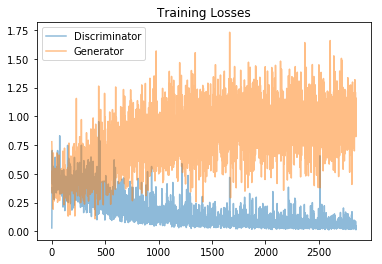

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

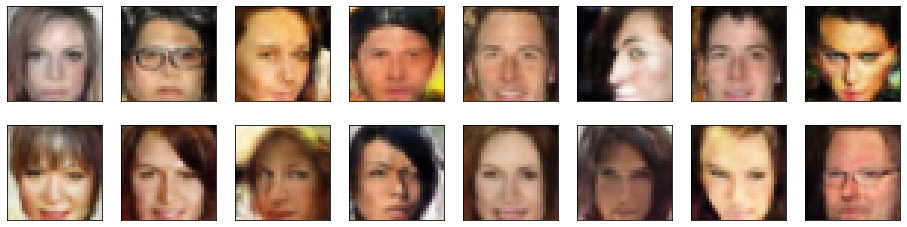

In [24]:
_ = view_samples(-1, samples)

In [ ]:
gen_samples(nrows=8)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

- Most images of the dataset don't contain the whole faces. It seems that most images are missing the chins. I am curious to see how the model would react if we make the dataset to contain the whole faces.
- The people in the dataset have their own styles, e.g. some have mustaches, some wear sunglasses, etc. I am wondering if it can help the model to converge if we use the dataset that have the images of the people with similar styles, e.g. a dataset that contains only the people with no mustache.
- While I was doing the research for this project, I heard that multiple fully connected layers can improve the performance of GANs.
- Also, residual networks like we used in CycleGAN may improve the model.
- I added a kind of 'pre-training' step of the discriminator before the main training loop, and I think it helped.
- I heard that it can be helpful to create a small pool of images that are generated by the generators in the previous batches and use the pool to train the discriminator in the following batches.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.